Performance Metrics Comparison:
                     Accuracy Precision    Recall  F1 Score
Model                                                      
KNN                  0.981481  0.982716  0.981481  0.981575
SVM                       1.0       1.0       1.0       1.0
Logistic Regression  0.981481  0.982716  0.981481  0.981575
Decision Tree        0.944444  0.947363  0.944444  0.944381


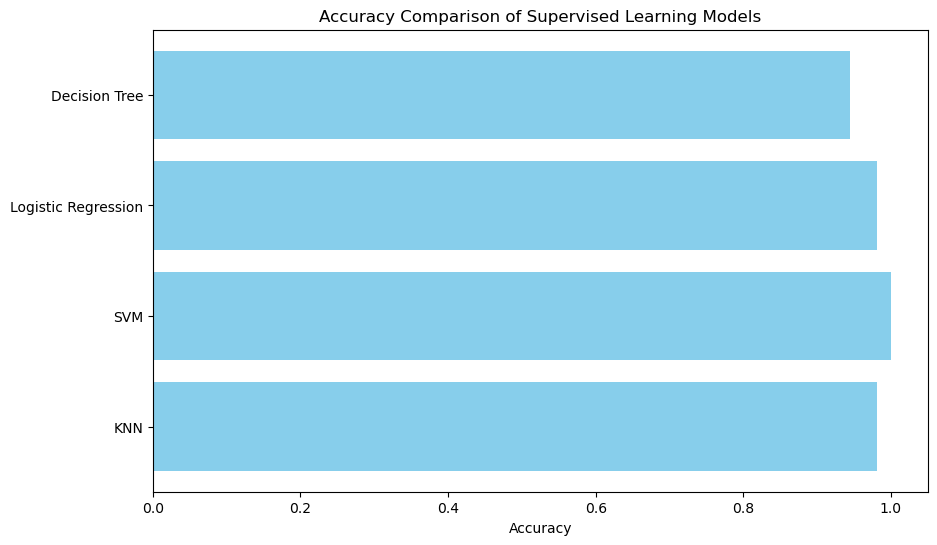

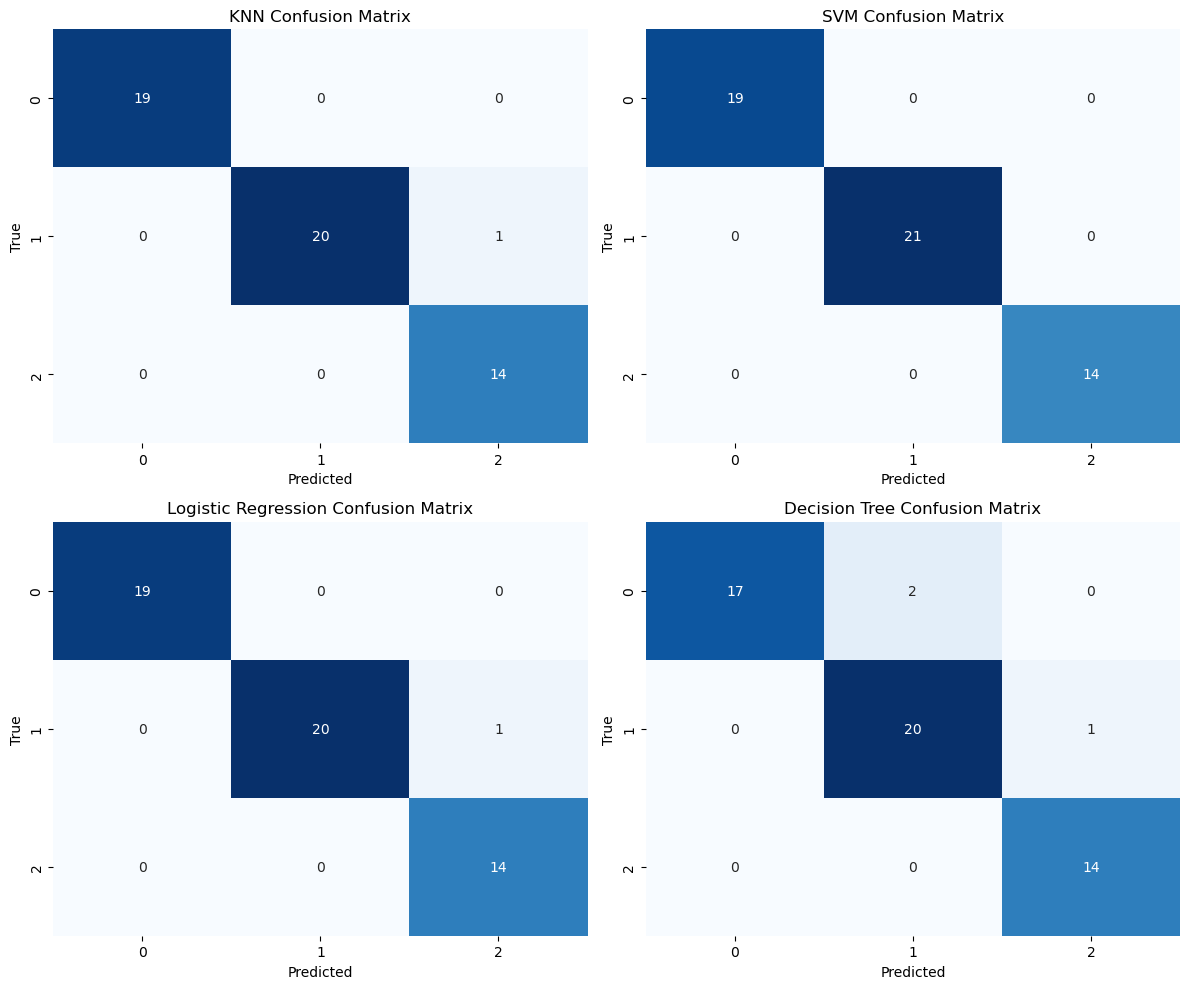


Best Parameters for each model:
KNN: {'algorithm': 'auto', 'n_neighbors': 25, 'weights': 'distance'}
SVM: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Logistic Regression: {'C': 1, 'max_iter': 100, 'solver': 'newton-cg'}
Decision Tree: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [14]:
# Import necessary libraries
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress specific FutureWarnings and ConvergenceWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors._classification")
warnings.filterwarnings("ignore", category=UserWarning, module="scipy")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load dataset (replace with actual dataset)
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Initialize models with hyperparameters tuning
param_grid_knn = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
param_grid_svc = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000]
}
param_grid_tree = {
    'max_depth': range(1, 21),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'criterion': ['gini', 'entropy']
}

models = {
    "KNN": (KNeighborsClassifier(), param_grid_knn),
    "SVM": (SVC(), param_grid_svc),
    "Logistic Regression": (LogisticRegression(), param_grid_logreg),
    "Decision Tree": (DecisionTreeClassifier(), param_grid_tree)
}

# Train, tune, and evaluate each model
results = {}
performance_metrics = {}
conf_matrices = {}

for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = accuracy
    performance_metrics[name] = {
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Create a DataFrame for performance metrics
performance_df = pd.DataFrame(performance_metrics).T

# Display the performance metrics in a nicely formatted table
performance_df_display = performance_df.drop(columns=['Best Parameters'])
performance_df_display.index.name = 'Model'
performance_df_display.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

print("Performance Metrics Comparison:")
print(performance_df_display)

# Plot accuracy comparison
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy Comparison of Supervised Learning Models')
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

# Display the best parameters for each model
print("\nBest Parameters for each model:")
for model, params in performance_df['Best Parameters'].items():
    print(f"{model}: {params}")
